### 使用Diffusers生成蝴蝶实战

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import torchvision

def show_images(x):
    """给定一批图像，创建一个网格将其转换为PIL图像"""
    x = x * 0.5 + 0.5 # 将(-1, 1)范围转换为(0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

def make_grid(images,size=64):
    """给定一个PIL图像列表，将它们叠加成一行以便查看"""
    output_im = Image.new("RGB",(size*len(images),size))
    for i,im in enumerate(images):
        output_im.paste(im.resize((size,size)),(i*size,0))
    return output_im
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from diffusers import DDPMPipeline,DDPMScheduler

# 加载预设管道
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

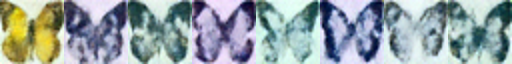

In [3]:
# 生成8张图片
images = butterfly_pipeline(batch_size=8).images

# 显示生成的图片
make_grid(images)

### 下载蝴蝶图片数据集

In [4]:
from datasets import load_dataset
dataset = load_dataset("./smithsonian_butterflies_subset",split="train")

Repo card metadata block was not found. Setting CardData to empty.


In [5]:
# 设置小参
batch_size = 64
image_size = 32

In [6]:
# 定义图像变换过程
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize((image_size,image_size)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5],[0.5])
])

In [7]:
# 定义一个适用于子集上的数据预处理函数
def transForms(example):
    images = [preprocess(image.convert("RGB")) for image in example["image"]]
    return {"images":images}

In [8]:
# 将预处理函数应用于数据集
dataset.set_transform(transForms)

In [9]:
# 创建一个数据加载器，用于批量提供经过处理的图像
train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
)

x shape: torch.Size([8, 3, 32, 32])


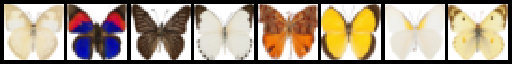

In [10]:
# 从数据集中获取一批图像
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("x shape:",xb.shape)
show_images(xb).resize((8 * 64, 64),resample=Image.NEAREST)

### 加载噪声调度器

In [11]:
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000
)

Noisy x shape: torch.Size([8, 3, 32, 32])


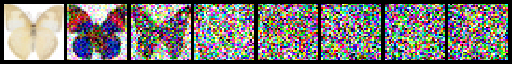

In [12]:
timesteps = torch.linspace(0,999,8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(
    xb,noise,timesteps
)
print("Noisy x shape:",noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64),resample=Image.NEAREST)

### 开始准备模型构建

In [13]:
# 从diffusers中导入UNet2D模型
from diffusers import UNet2DModel

In [14]:
# 定义一个属于我们自己的UNet2D模型
model = UNet2DModel(
    sample_size=image_size, # 输入图像的大小
    in_channels= 3, # 输入图像的通道数
    out_channels=3, # 输出图像的通道数
    layers_per_block=2, # 每个UNet块中使用的ResNet层数
    block_out_channels=(64,128,128,256), # 每个UNet块中的输出通道数
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D",    
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    ),
).to(device)

In [15]:
with torch.no_grad():
    model_prediciton = model(noisy_xb,timesteps).sample

model_prediciton.shape

torch.Size([8, 3, 32, 32])

### 创建PytorchLightning模块

In [16]:
import pytorch_lightning as pl

In [29]:
# 定义一个PyTorch Lightning模型
class LightningModel(pl.LightningModule):
    def __init__(self,model):
        super().__init__()
        self.model = model.to(device)
        self.noise_scheduler = DDPMScheduler(
            num_train_timesteps=1000,
            beta_schedule="squaredcos_cap_v2"
        )
        self.loss_method = torch.nn.functional.mse_loss
        self.loss_metrics= []
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=4e-4,
        )
        self.loss = None
    def training_step(self,batch,batch_idx):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        timesteps = torch.randint(
            0,noise_scheduler.num_train_timesteps,(clean_images.shape[0],)
        ).to(device).long()
        noisy_images = noise_scheduler.add_noise(
            clean_images,noise,timesteps
        )
        noise_pred = model(noisy_images,timesteps,return_dict=False)[0]
        self.loss = self.loss_method(noise_pred,noise)
        self.loss.backward(self.loss)
        self.loss_metrics.append(self.loss.item())
        self.optimizer.step()
        self.optimizer.zero_grad()
    def configure_optimizers(self):
        return self.optimizer
    def plot_loss(self):
        plt.plot(self.loss_metrics)
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.show()

In [30]:
# 创建一个PyTorch Lightning Trainer
trainer = pl.Trainer(
    accumulate_grad_batches=5,
    max_epochs=50
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [31]:
# 训练模型
lightning_model = LightningModel(model)
trainer.fit(lightning_model,train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | UNet2DModel | 18.5 M
--------------------------------------
18.5 M    Trainable params
0         Non-trainable params
18.5 M    Total params
74.145    Total estimated model params size (MB)
/root/anaconda3/envs/hugging/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/anaconda3/envs/hugging/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want

Training: 0it [00:00, ?it/s]

/root/anaconda3/envs/hugging/lib/python3.11/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/root/anaconda3/envs/hugging/lib/python3.11/site-packages/pytorch_lightning/loops/optimization/automatic.py:131: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")
`Trainer.fit` stopped: `max_epochs=50` reached.


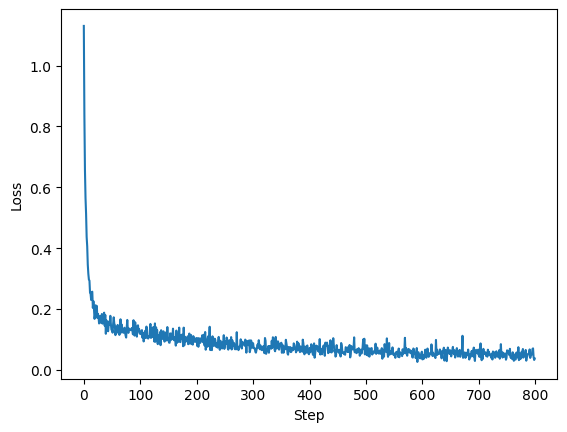

In [32]:
lightning_model.plot_loss()

In [33]:
model = lightning_model.model
scheduler = lightning_model.noise_scheduler

### 利用我们刚才的模型生成一张图像

In [34]:
from diffusers import DDPMPipeline

# 从预训练管道中加载模型
butterfly_pipeline = DDPMPipeline(
    unet=model,
    scheduler=noise_scheduler,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

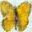

In [35]:
# 生成1张图片
output = butterfly_pipeline()
output.images[0]

In [57]:
# 保存我们的pipeline
butterfly_pipeline.save_pretrained("my-pipeline")